In [ ]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.1.0+cu121


In [ ]:
%%capture
# Download the corresponding PyTorch Geometric module
%env TORCH=2.1.0+cu121
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv, global_mean_pool, MessagePassing
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng()

## **Generating the dataset.**

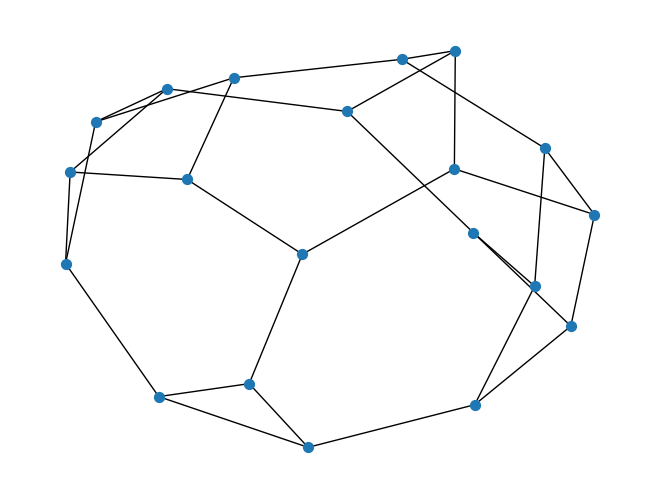

In [ ]:
N = 1000
FEATURE_RANGE = 100
TRAINING_N_NODES = 20
TESTING_N_NODES = 20

training_graphs = []
testing_graphs = []

training_dataset = []
testing_dataset = []

training_adjs = []
training_xs = []
training_ys = []

testing_adjs = []
testing_xs = []
testing_ys = []

def networkx_to_geom(graph):
    sources = []
    targets = []
    for u, v in graph.edges:
        sources.append(u)
        targets.append(v)
    edge_index = torch.LongTensor([sources + targets, targets + sources])
    n = graph.number_of_nodes()
    x = torch.zeros((n, 0))
    # x = torch.full((n, 1), 1)
    graph_triangles = nx.triangles(graph)
    y = torch.tensor([min(1, graph_triangles[node]) for node in sorted(graph.nodes)])
    return Data(edge_index=edge_index, x=x, y=y)

def construct_dataset(graph):
    n = graph.number_of_nodes()
    adj = torch.zeros((n, n))
    for u, v in graph.edges:
        adj[u, v] = 1
        adj[v, u] = 1
    # x = torch.zeros((n, 0))
    x = torch.full((n, 1), 1)
    graph_triangles = nx.triangles(graph)
    y = torch.tensor([min(1, graph_triangles[node]) for node in sorted(graph.nodes)])
    return adj, x, y

for i in range(N):
    training_graph = nx.random_regular_graph(3, TRAINING_N_NODES)
    training_graph_triangles = nx.triangles(training_graph)
    training_graphs.append(training_graph)
    adj, x, y = construct_dataset(training_graph)
    training_adjs.append(adj)
    training_xs.append(x)
    training_ys.append(y)
    training_dataset.append(networkx_to_geom(training_graph))

    testing_graph = nx.random_regular_graph(3, TESTING_N_NODES)
    testing_graph_triangles = nx.triangles(testing_graph)
    testing_graphs.append(testing_graph)
    adj, x, y = construct_dataset(testing_graph)
    testing_adjs.append(adj)
    testing_xs.append(x)
    testing_ys.append(y)
    testing_dataset.append(networkx_to_geom(testing_graph))

nx.draw(training_graphs[0], node_size=50)
plt.show()

## **Defining models**

In [ ]:
class GINConv(MessagePassing):
    def __init__(self, mlp, aggr="add"):
        '''
            emb_dim (int): node embedding dimensionality
        '''
        super(GINConv, self).__init__(aggr = aggr)

        self.mlp = mlp
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

    def forward(self, x, edge_index):
        out = self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x))
        return out

    def message(self, x_j):
        return nn.functional.relu(x_j)

    def update(self, aggr_out):
        return aggr_out

In [ ]:
class MLPModule(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=5):
        super().__init__()
        layers = []
        if num_layers == 1:
            layers = [nn.Linear(input_dim, output_dim)]
        else:
            layers.extend([nn.Linear(input_dim, hidden_dim), nn.ReLU()])
            for _ in range(num_layers - 2):
                layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
            layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers_sequential = nn.Sequential(*layers)

    def forward(self, x):
      return self.layers_sequential(x)

In [ ]:
class RGIN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=2, random_feature_range=100, num_layers=5, aggr="add"):
        super().__init__()
        self.random = random_feature_range
        self.layers = nn.ModuleList([])
        for i in range(num_layers):
            if i == 0:
                mlp = MLPModule(input_dim + 1, hidden_dim, hidden_dim, num_layers=2)
                self.layers.append(GINConv(mlp, aggr=aggr))
            else:
                mlp = MLPModule(hidden_dim, hidden_dim, hidden_dim, num_layers=2)
                self.layers.append(GINConv(mlp, aggr=aggr))
        self.mlp = MLPModule(hidden_dim, hidden_dim, output_dim, num_layers=1)

    def forward(self, batch):
        return self.mlp(self.get_node_embeddings(batch))

    def get_node_embeddings(self, batch):
        x = batch.x
        edge_index = batch.edge_index
        rand_features = torch.randint(self.random, size=(x.size()[0], 1)) / self.random
        x = torch.cat([x, rand_features], axis=1)
        for layer in self.layers:
            x = layer(x, edge_index)
        return x

    def reset_parameters(self):
        def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

        _reset_module_parameters(self)


In [ ]:
class GIN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=2, num_layers=5, aggr="add"):
        super().__init__()
        self.layers = nn.ModuleList([])
        for i in range(num_layers):
            if i == 0:
                mlp = MLPModule(input_dim, hidden_dim, hidden_dim, num_layers=2)
                self.layers.append(GINConv(mlp, aggr=aggr))
            else:
                mlp = MLPModule(hidden_dim, hidden_dim, hidden_dim, num_layers=2)
                self.layers.append(GINConv(mlp, aggr=aggr))
        self.mlp = MLPModule(hidden_dim, hidden_dim, output_dim, num_layers=1)

    def forward(self, batch):
        return self.mlp(self.get_node_embeddings(batch))

    def get_node_embeddings(self, batch):
        x = batch.x
        edge_index = batch.edge_index
        for layer in self.layers:
            x = layer(x, edge_index)
        return x

    def reset_parameters(self):
        def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

        _reset_module_parameters(self)


## **Training the models**

In [ ]:
NUM_EPOCHS = 4000
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0

In [ ]:
def train(model, train_dataloader, test_dataloader):
    model.reset_parameters()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    test_accuracies = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        for data in train_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total_num = 0
        for data in test_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            correct += (pred.argmax(dim=-1) == data.y).sum()
            total_num += len(data.y)
        test_accuracy = correct / total_num
        test_accuracies.append(test_accuracy)
        if epoch % 10 == 0:
            print("epoch={}, loss={}, accuracy={}".format(epoch, loss.item(), test_accuracy))

    return test_accuracies


In [ ]:
model_baseline = GIN(input_dim=0, hidden_dim=64, num_layers=3).to(device)
train_dataloader = DataLoader(training_dataset, batch_size=32)
test_dataloader = DataLoader(testing_dataset, batch_size=32)

print(model_baseline)
test_accuracies_baseline = train(model_baseline, train_dataloader, test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


GIN(
  (layers): ModuleList(
    (0-2): 3 x GINConv()
  )
  (mlp): MLPModule(
    (layers_sequential): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
epoch=0, loss=0.6224333643913269, accuracy=0.7366999983787537
epoch=10, loss=0.6286489367485046, accuracy=0.7366999983787537
epoch=20, loss=0.6279091835021973, accuracy=0.7366999983787537
epoch=30, loss=0.627548336982727, accuracy=0.7366999983787537
epoch=40, loss=0.6273932456970215, accuracy=0.7366999983787537
epoch=50, loss=0.6273245811462402, accuracy=0.7366999983787537
epoch=60, loss=0.6272757649421692, accuracy=0.7366999983787537
epoch=70, loss=0.6272250413894653, accuracy=0.7366999983787537
epoch=80, loss=0.6271738409996033, accuracy=0.7366999983787537
epoch=90, loss=0.6271142959594727, accuracy=0.7366999983787537
epoch=100, loss=0.6270520687103271, accuracy=0.7366999983787537
epoch=110, loss=0.6269892454147339, accuracy=0.7366999983787537
epoch=120, loss=0.6269267797470093, accuracy=0.736699998

In [ ]:
model_add = RGIN(input_dim=0, hidden_dim=64, num_layers=3, aggr="add").to(device)
train_dataloader = DataLoader(training_dataset, batch_size=32)
test_dataloader = DataLoader(testing_dataset, batch_size=32)

print(model_add)
test_accuracies_add = train(model_add, train_dataloader, test_dataloader)

RGIN(
  (layers): ModuleList(
    (0-2): 3 x GINConv()
  )
  (mlp): MLPModule(
    (layers_sequential): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
epoch=0, loss=0.643019437789917, accuracy=0.7587000131607056
epoch=10, loss=0.6230363845825195, accuracy=0.7587000131607056
epoch=20, loss=0.6178432106971741, accuracy=0.7587000131607056
epoch=30, loss=0.605571448802948, accuracy=0.758400022983551
epoch=40, loss=0.5524275302886963, accuracy=0.7587000131607056
epoch=50, loss=0.5986661911010742, accuracy=0.7627000212669373
epoch=60, loss=0.6082404255867004, accuracy=0.7600499987602234
epoch=70, loss=0.5211256742477417, accuracy=0.7599999904632568
epoch=80, loss=0.5347504019737244, accuracy=0.755649983882904
epoch=90, loss=0.5501657724380493, accuracy=0.760200023651123
epoch=100, loss=0.5289343595504761, accuracy=0.7648500204086304
epoch=110, loss=0.5185700058937073, accuracy=0.7616999745368958
epoch=120, loss=0.5770865082740784, accuracy=0.764900028705

In [ ]:
model_mean = RGIN(input_dim=0, hidden_dim=64, num_layers=3, aggr="mean").to(device)
train_dataloader = DataLoader(training_dataset, batch_size=32)
test_dataloader = DataLoader(testing_dataset, batch_size=32)

print(model_mean)
test_accuracies_mean = train(model_mean, train_dataloader, test_dataloader)

RGIN(
  (layers): ModuleList(
    (0-2): 3 x GINConv()
  )
  (mlp): MLPModule(
    (layers_sequential): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
epoch=0, loss=0.6502988338470459, accuracy=0.7587000131607056
epoch=10, loss=0.6431635618209839, accuracy=0.7587000131607056
epoch=20, loss=0.6424400210380554, accuracy=0.7587000131607056
epoch=30, loss=0.6422396898269653, accuracy=0.7587000131607056
epoch=40, loss=0.6401668190956116, accuracy=0.7587000131607056
epoch=50, loss=0.6435173749923706, accuracy=0.7587000131607056
epoch=60, loss=0.6415014266967773, accuracy=0.7590000033378601
epoch=70, loss=0.6441396474838257, accuracy=0.7587000131607056
epoch=80, loss=0.6410051584243774, accuracy=0.7587000131607056
epoch=90, loss=0.651206374168396, accuracy=0.7587000131607056
epoch=100, loss=0.6213058233261108, accuracy=0.7587000131607056
epoch=110, loss=0.5792982578277588, accuracy=0.7592499852180481
epoch=120, loss=0.5848771333694458, accuracy=0.75814998

In [ ]:
model_max = RGIN(input_dim=0, hidden_dim=64, num_layers=3, aggr="max").to(device)
train_dataloader = DataLoader(training_dataset, batch_size=32)
test_dataloader = DataLoader(testing_dataset, batch_size=32)

print(model_max)
test_accuracies_max = train(model_max, train_dataloader, test_dataloader)

RGIN(
  (layers): ModuleList(
    (0-2): 3 x GINConv()
  )
  (mlp): MLPModule(
    (layers_sequential): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)
epoch=0, loss=0.6362622976303101, accuracy=0.7587000131607056
epoch=10, loss=0.6303948163986206, accuracy=0.7587000131607056
epoch=20, loss=0.614993691444397, accuracy=0.7587000131607056
epoch=30, loss=0.6033926010131836, accuracy=0.7587000131607056
epoch=40, loss=0.6066738367080688, accuracy=0.7587000131607056
epoch=50, loss=0.5949519276618958, accuracy=0.7587000131607056
epoch=60, loss=0.6288838982582092, accuracy=0.7587000131607056
epoch=70, loss=0.6143643260002136, accuracy=0.7587000131607056
epoch=80, loss=0.6231306195259094, accuracy=0.7591999769210815
epoch=90, loss=0.6097944974899292, accuracy=0.758899986743927
epoch=100, loss=0.6094628572463989, accuracy=0.7588000297546387
epoch=110, loss=0.6054395437240601, accuracy=0.7599999904632568
epoch=120, loss=0.5951554775238037, accuracy=0.758700013

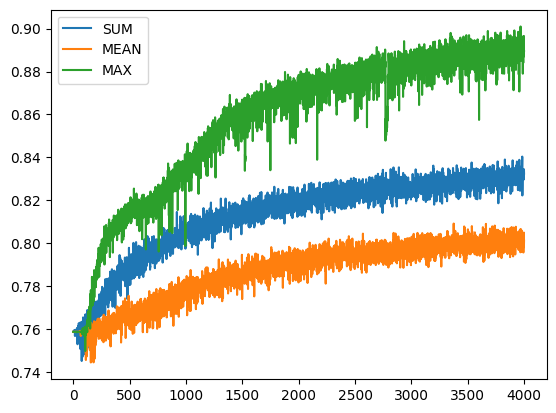

In [ ]:
line_add, = plt.plot(test_accuracies_add, label="SUM")
line_mean, = plt.plot(test_accuracies_mean, label="MEAN")
line_max, = plt.plot(test_accuracies_max, label="MAX")
plt.legend(handles=[line_add, line_mean, line_max])
plt.show()

In [ ]:
def train_further(model, train_dataloader, test_dataloader, further_epochs):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    test_accuracies = []

    for epoch in range(further_epochs):
        model.train()
        for data in train_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total_num = 0
        for data in test_dataloader:
            optimizer.zero_grad()
            pred = model(data)
            correct += (pred.argmax(dim=-1) == data.y).sum()
            total_num += len(data.y)
        test_accuracy = correct / total_num
        test_accuracies.append(test_accuracy)
        if epoch % 100 == 0:
            print("epoch={}, loss={}, accuracy={}".format(epoch, loss.item(), test_accuracy))

    return test_accuracies


In [ ]:
FURTHER_EPOCHS = 6000

test_accuracies_add += train_further(model_add, train_dataloader, test_dataloader, FURTHER_EPOCHS)

epoch=0, loss=0.3943329453468323, accuracy=0.8325999975204468
epoch=100, loss=0.36491960287094116, accuracy=0.8370500206947327
epoch=200, loss=0.37390726804733276, accuracy=0.8362500071525574
epoch=300, loss=0.390636682510376, accuracy=0.8349999785423279
epoch=400, loss=0.3346232771873474, accuracy=0.8337500095367432
epoch=500, loss=0.45859813690185547, accuracy=0.8288499712944031
epoch=600, loss=0.400522381067276, accuracy=0.8367499709129333
epoch=700, loss=0.26295360922813416, accuracy=0.8327999711036682
epoch=800, loss=0.3813261091709137, accuracy=0.8329499959945679
epoch=900, loss=0.28264087438583374, accuracy=0.8336499929428101
epoch=1000, loss=0.3096776008605957, accuracy=0.8368499875068665
epoch=1100, loss=0.3536416292190552, accuracy=0.8343499898910522
epoch=1200, loss=0.40080970525741577, accuracy=0.8355500102043152
epoch=1300, loss=0.3309420645236969, accuracy=0.8359000086784363
epoch=1400, loss=0.36626195907592773, accuracy=0.8372499942779541
epoch=1500, loss=0.4245555400848

In [ ]:
test_accuracies_mean += train_further(model_mean, train_dataloader, test_dataloader, FURTHER_EPOCHS)
test_accuracies_max += train_further(model_max, train_dataloader, test_dataloader, FURTHER_EPOCHS)

epoch=0, loss=0.4143882393836975, accuracy=0.8010500073432922
epoch=100, loss=0.502627968788147, accuracy=0.8036500215530396
epoch=200, loss=0.4614243507385254, accuracy=0.802049994468689
epoch=300, loss=0.5141351819038391, accuracy=0.8040500283241272
epoch=400, loss=0.4510462284088135, accuracy=0.7971500158309937
epoch=500, loss=0.413644403219223, accuracy=0.8028500080108643
epoch=600, loss=0.37426450848579407, accuracy=0.8076000213623047
epoch=700, loss=0.473585844039917, accuracy=0.8037999868392944
epoch=800, loss=0.407754123210907, accuracy=0.802049994468689
epoch=900, loss=0.3637402057647705, accuracy=0.805899977684021
epoch=1000, loss=0.440335750579834, accuracy=0.8051000237464905
epoch=1100, loss=0.45876574516296387, accuracy=0.8031499981880188
epoch=1200, loss=0.364050030708313, accuracy=0.8105000257492065
epoch=1300, loss=0.471330463886261, accuracy=0.8062000274658203
epoch=1400, loss=0.4204352796077728, accuracy=0.8053500056266785
epoch=1500, loss=0.4823870062828064, accuracy

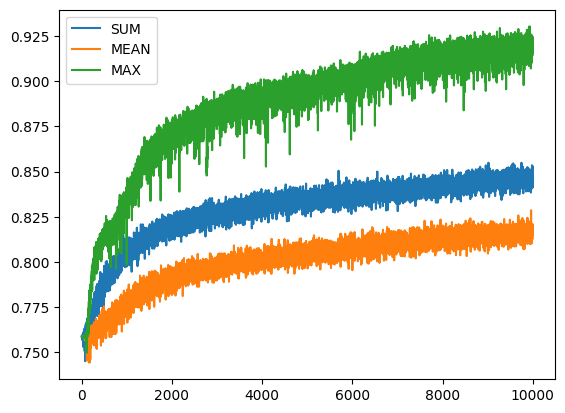

In [ ]:
line_add, = plt.plot(test_accuracies_add, label="SUM")
line_mean, = plt.plot(test_accuracies_mean, label="MEAN")
line_max, = plt.plot(test_accuracies_max, label="MAX")
plt.legend(handles=[line_add, line_mean, line_max])
plt.show()

In [ ]:
FURTHER_EPOCHS = 10000

test_accuracies_add += train_further(model_add, train_dataloader, test_dataloader, FURTHER_EPOCHS)
test_accuracies_mean += train_further(model_mean, train_dataloader, test_dataloader, FURTHER_EPOCHS)
test_accuracies_max += train_further(model_max, train_dataloader, test_dataloader, FURTHER_EPOCHS)

epoch=0, loss=0.3439851701259613, accuracy=0.8479999899864197
epoch=100, loss=0.3058996796607971, accuracy=0.8425499796867371
epoch=200, loss=0.30040091276168823, accuracy=0.8511499762535095
epoch=300, loss=0.36350440979003906, accuracy=0.8475499749183655
epoch=400, loss=0.4283817410469055, accuracy=0.8525000214576721
epoch=500, loss=0.3009691834449768, accuracy=0.8438000082969666
epoch=600, loss=0.3752991259098053, accuracy=0.8464999794960022
epoch=700, loss=0.31816983222961426, accuracy=0.8458499908447266
epoch=800, loss=0.33227768540382385, accuracy=0.8486499786376953
epoch=900, loss=0.3419426381587982, accuracy=0.8527500033378601
epoch=1000, loss=0.3191017508506775, accuracy=0.8536499738693237
epoch=1100, loss=0.3327149450778961, accuracy=0.8471999764442444
epoch=1200, loss=0.3232993483543396, accuracy=0.8511999845504761
epoch=1300, loss=0.4198826849460602, accuracy=0.8436999917030334
epoch=1400, loss=0.2719360589981079, accuracy=0.8454499840736389
epoch=1500, loss=0.29437109827995

In [ ]:
print(f"Final test accuracy for ADD: {test_accuracies_add[-1]}")
print(f"Final test accuracy for MEAN: {test_accuracies_mean[-1]}")
print(f"Final test accuracy for MAX: {test_accuracies_max[-1]}")

Final test accuracy for ADD: 0.8602499961853027
Final test accuracy for MEAN: 0.8212500214576721
Final test accuracy for MAX: 0.9355499744415283


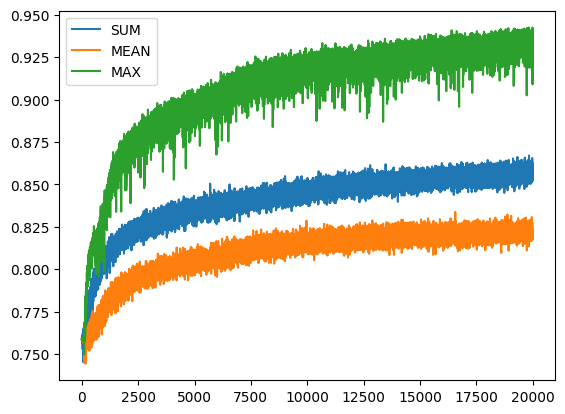

In [ ]:
line_add, = plt.plot(test_accuracies_add, label="SUM")
line_mean, = plt.plot(test_accuracies_mean, label="MEAN")
line_max, = plt.plot(test_accuracies_max, label="MAX")
plt.legend(handles=[line_add, line_mean, line_max])
plt.show()